# Neural Machine Translation

Welcome to your first programming assignment for this week! 

* You will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). 
* You will do this using an attention model, one of the most sophisticated sequence-to-sequence models. 

This notebook was produced together with NVIDIA's Deep Learning Institute. 

## <font color='darkblue'>Updates</font>

#### If you were working on the notebook before this update...
* The current notebook is version "4a".
* You can find your original work saved in the notebook with the previous version name ("v4") 
* To view the file directory, go to the menu "File->Open", and this will open a new tab that shows the file directory.

#### List of updates
* Clarified names of variables to be consistent with the lectures and consistent within the assignment
    - pre-attention bi-directional LSTM: the first LSTM that processes the input data.
        - 'a': the hidden state of the pre-attention LSTM.
    - post-attention LSTM: the LSTM that outputs the translation.
        - 's': the hidden state of the post-attention LSTM.
    - energies "e".  The output of the dense function that takes "a" and "s" as inputs.
    - All references to "output activation" are updated to "hidden state".
    - "post-activation" sequence model is updated to "post-attention sequence model".
    - 3.1: "Getting the activations from the Network" renamed to "Getting the attention weights from the network."
    - Appropriate mentions of "activation" replaced "attention weights."
    - Sequence of alphas corrected to be a sequence of "a" hidden states.
* one_step_attention:
    - Provides sample code for each Keras layer, to show how to call the functions.
    - Reminds students to provide the list of hidden states in a specific order, in order to pause the autograder.
* model
    - Provides sample code for each Keras layer, to show how to call the functions.
    - Added a troubleshooting note about handling errors.
    - Fixed typo: outputs should be of length 10 and not 11.
* define optimizer and compile model
    - Provides sample code for each Keras layer, to show how to call the functions.

* Spelling, grammar and wording corrections.

Let's load all the packages you will need for this assignment.

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates

* The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. 
* However, language translation requires massive datasets and usually takes days of training on GPUs. 
* To give you a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 
* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) 
* The network will translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 
* We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 17593.71it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [4]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34,
 '<unk>': 35,
 '<pad>': 36}

##### Function to convert dataset to integers. 
nmt_utils.py has is. Here is my vesion

In [5]:
# there is a mistake in original function: vocab.get(x, '<unk>') will get <unk> but not an integer
def str_to_int(string, T, vocab):
    string = string.lower()
    string = string.replace(',', '')
    string = [vocab.get(i, vocab['<unk>']) for i in string]
    if len(string)>T:
        string = string[:T]
    else:
        string = string + (T-len(string))*[vocab['<pad>']]
    return string

In [6]:
Tx = 30
Ty = 10
X, Y = zip(*dataset)

In [7]:
X = np.array([str_to_int(sent, Tx, human_vocab) for sent in X])

In [8]:
X

array([[12,  0, 24, ..., 36, 36, 36],
       [ 4,  3,  1, ..., 36, 36, 36],
       [12,  2,  4, ..., 36, 36, 36],
       ...,
       [25, 26, 32, ..., 36, 36, 36],
       [24, 26, 25, ..., 36, 36, 36],
       [ 3,  9,  0, ..., 36, 36, 36]])

In [9]:
str_to_int('saturday, **april** 28 1990', 30, human_vocab)

[29,
 13,
 30,
 31,
 28,
 16,
 13,
 34,
 0,
 35,
 35,
 13,
 27,
 28,
 21,
 23,
 35,
 35,
 0,
 5,
 11,
 0,
 4,
 12,
 12,
 3,
 36,
 36,
 36,
 36]

In [10]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [11]:
X

array([[12,  0, 24, ..., 36, 36, 36],
       [ 4,  3,  1, ..., 36, 36, 36],
       [12,  2,  4, ..., 36, 36, 36],
       ...,
       [25, 26, 32, ..., 36, 36, 36],
       [24, 26, 25, ..., 36, 36, 36],
       [ 3,  9,  0, ..., 36, 36, 36]])

In [12]:
Y

array([[ 2, 10, 10, ...,  0,  1, 10],
       [ 3,  1,  2, ...,  0,  2,  1],
       [ 2, 10,  8, ...,  0,  2,  1],
       ...,
       [ 3,  1,  1, ...,  0,  1,  3],
       [ 2, 10, 10, ...,  0,  2,  4],
       [ 3,  1,  3, ...,  0,  1,  7]])

In [13]:
Xoh.shape

(10000, 30, 37)

You now have:
- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Tx, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

* Let's also look at some examples of preprocessed training examples. 
* Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

In [14]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2 - Neural machine translation with attention

* If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. 
* Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


### 2.1 - Attention mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. 
* Here is a figure to remind you how the model works. 
    * The diagram on the left shows the attention model. 
    * The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
    * The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


Here are some properties of the model that you may notice: 

#### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

#### An LSTM has both a hidden state and cell state
* In the lecture videos, we were using only a basic RNN for the post-attention sequence model
    * This means that the state captured by the RNN was outputting only the hidden state $s^{\langle t\rangle}$. 
* In this assignment, we are using an LSTM instead of a basic RNN.
    * So the LSTM has both the hidden state $s^{\langle t\rangle}$ and the cell state $c^{\langle t\rangle}$. 

#### Each time step does not use predictions from the previous time step
* Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- Recall in the lesson videos "Attention Model", at time 6:45 to 8:16, the definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
    - "e" is called the "energies" variable.
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
    - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ is then used when computing the attention $a^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

- The diagram on the right of figure 1 uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
- Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

### Implementation Details
   
Let's implement this neural translator. You will start by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

##### Clarifying 'context' and 'c'
- In the lecture videos, the context was denoted $c^{\langle t \rangle}$
- In the assignment, we are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

#### Implement `one_step_attention`

**Exercise**: Implement `one_step_attention()`. 

* The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 
* Here's how you can implement layers with shareable weights in Keras:
    1. Define the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables would work.
        - Note that defining these variables inside the scope of the function `model` would technically work, since `model` will then call the `one_step_attention` function.  For the purposes of making grading and troubleshooting easier, we are defining these as global variables.  Note that the automatic grader will expect these to be global variables as well.
    2. Call these objects when propagating the input.
* We have defined the layers you need as global variables. 
    * Please run the following cells to create them. 
    * Please note that the automatic grader expects these global variables with the given variable names.  For grading purposes, please do not rename the global variables.
* Please check the Keras documentation to learn more about these layers.  The layers are functions.  Below are examples of how to call these functions.
    * [RepeatVector()](https://keras.io/layers/core/#repeatvector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://keras.io/layers/merge/#concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://keras.io/layers/merge/#dot)  
```Python
dot_product = dot_layer([var1,var2])
```

In [15]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [16]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev) 
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a,s_prev]) 
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat) 
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e) 
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies) 
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a]) 
    ### END CODE HERE ###
    
    return context

You will be able to check the expected output of `one_step_attention()` after you've coded the `model()` function.

#### model
* `model` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `model` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$. 

**Exercise**: Implement `model()` as explained in figure 1 and the text above. Again, we have defined global layers that will share weights to be used in `model()`.

In [17]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
# For the purposes of passing the automatic grader
# please do not modify this global variable.  This will be corrected once the automatic grader is also updated.
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input `X` into a bi-directional LSTM.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Remember that we want the LSTM to return a full sequence instead of just the last hidden state.  
    
Sample code:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Iterate for $t = 0, \cdots, T_y-1$: 
    1. Call `one_step_attention()`, passing in the sequence of hidden states $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ from the pre-attention bi-directional LSTM, and the previous hidden state $s^{<t-1>}$ from the post-attention LSTM to calculate the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. 
        - Remember to pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM 
        * This outputs the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.  

        Sample code:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        Please note that the layer is actually the "post attention LSTM cell".  For the purposes of passing the automatic grader, please do not modify the naming of this global variable.  This will be fixed when we deploy updates to the automatic grader.
    3. Apply a dense, softmax layer to $s^{<t>}$, get the output.  
        Sample code:
        ```Python
        output = output_layer(inputs=...)
        ```
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance.
    * It should have three inputs:
        * `X`, the one-hot encoded inputs to the model, of shape ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, the initial hidden state of the post-attention LSTM
        * $c^{\langle 0 \rangle}$), the initial cell state of the post-attention LSTM
    * The output is the list of outputs.  
    Sample code
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [18]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(m, Tx, n_a*2))(X)  
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c] ) 
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model.

In [19]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

#### Troubleshooting Note
* If you are getting repeated errors after an initially incorrect implementation of "model", but believe that you have corrected the error, you may still see error messages when building your model.  
* A solution is to save and restart your kernel (or shutdown then restart your notebook), and re-run the cells.

Let's get a summary of the model to check if it matches the expected output.

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                   

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


#### Compile the model
* After creating your model in Keras, you need to compile it and define the loss function, optimizer and metrics you want to use. 
    * Loss function: 'categorical_crossentropy'.
    * Optimizer: [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers)
        - learning rate = 0.005 
        - $\beta_1 = 0.9$
        - $\beta_2 = 0.999$
        - decay = 0.01  
    * metric: 'accuracy'
    
Sample code
```Python
optimizer = Adam(lr=..., beta_1=..., beta_2=..., decay=...)
model.compile(optimizer=..., loss=..., metrics=[...])
```

In [21]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999,decay=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
### END CODE HERE ###

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Define inputs and outputs, and fit the model
The last step is to define all your inputs and outputs to fit the model:
- You have input X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_attention_LSTM_cell` with zeros.
- Given the `model()` you coded, you need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [37]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [31]:
Yoh.shape

(10000, 10, 11)

In [32]:
list(Yoh.swapaxes(0,1))[0].shape

(10000, 11)

Let's now fit the model and run it for one epoch.

In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=100, batch_size=100)

Epoch 1/100
100/100 [==============================] - 11s 109ms/step - loss: 0.8847 - dense_2_loss: 0.0195 - dense_2_1_loss: 0.0132 - dense_2_2_loss: 0.2053 - dense_2_3_loss: 0.1188 - dense_2_4_loss: 5.3906e-04 - dense_2_5_loss: 0.0283 - dense_2_6_loss: 0.1874 - dense_2_7_loss: 1.9644e-04 - dense_2_8_loss: 0.1189 - dense_2_9_loss: 0.1925 - dense_2_accuracy: 0.9948 - dense_2_1_accuracy: 0.9952 - dense_2_2_accuracy: 0.9084 - dense_2_3_accuracy: 0.9719 - dense_2_4_accuracy: 1.0000 - dense_2_5_accuracy: 0.9904 - dense_2_6_accuracy: 0.9450 - dense_2_7_accuracy: 1.0000 - dense_2_8_accuracy: 0.9685 - dense_2_9_accuracy: 0.9323
Epoch 11/100
100/100 [==============================] - 12s 122ms/step - loss: 0.8400 - dense_2_loss: 0.0183 - dense_2_1_loss: 0.0120 - dense_2_2_loss: 0.1956 - dense_2_3_loss: 0.1142 - dense_2_4_loss: 5.1382e-04 - dense_2_5_loss: 0.0272 - dense_2_6_loss: 0.1798 - dense_2_7_loss: 1.8123e-04 - dense_2_8_loss: 0.1091 - dense_2_9_loss: 0.1833 - dense_2_accuracy: 0.9955 - 

While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [28]:
import os
os.getcwd()

'/home/jupyter/coursera-deep-learning-specialization/C5 - Sequence Models/Week 3/Machine Translation'

In [27]:
model.load_weights('models/model.h5')

OSError: Unable to open file (file signature not found)

In [42]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001',
           'I love my dog', 'may 3th', 'may 4th 1999y', '4 may 1999', '10th may 1878']

# change initial hidden state and cell state for post-LSTM, since there is only one example now (for training there was 1000 examples)
s0 = np.zeros((1, n_s))
c0 = np.zeros((1, n_s))

for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.expand_dims(source, axis=0) # add first dimension (output shape: (1,30,37), --> one example()) 
    
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print(f"example: {example},  output: {''.join(output)}")

example: 3 May 1979,  output: 1979-05-03
example: 5 April 09,  output: 2009-04-04
example: 21th of August 2016,  output: 2016-08-11
example: Tue 10 Jul 2007,  output: 2007-07-10
example: Saturday May 9 2018,  output: 2018-05-09
example: March 3 2001,  output: 2001-03-03
example: March 3rd 2001,  output: 2001-03-03
example: 1 March 2001,  output: 2001-03-01
example: I love my dog,  output: 1997-01-02
example: may 3th,  output: 2015-05-04
example: may 4th 1999y,  output: 1999-05-04
example: 4 may 1999,  output: 1999-05-04
example: 10th may 1878,  output: 1988-05-10


You can now see the results on new examples.

You can also change these examples to test with your own examples. The next part will give you a better sense of what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what each part of the output is looking at which part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We also see that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 

### 3.1 - Getting the attention weights from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [103]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                   

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Let's get the attention weights from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

<Figure size 432x288 with 0 Axes>

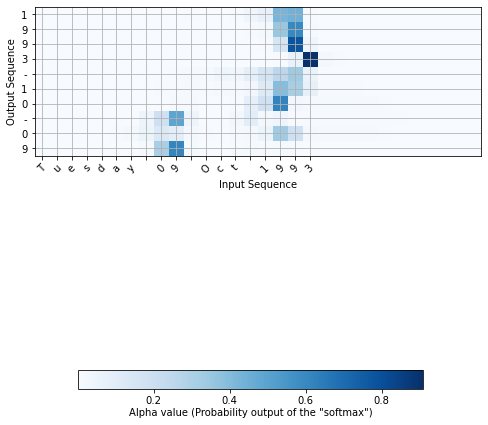

In [124]:
# num = 7  ---> layer number  attention_weights (Activation)  
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

In [107]:
model.layers[0]

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that the places where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and doesn't have much impact on predicting the day or month.

### Congratulations!


You have come to the end of this assignment 

## Here's what you should remember

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 